In [1]:
import os, sys, re, json, time
from importlib import reload
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import tensorflow as tf
from IPython.display import display, clear_output 
import time
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

/home/nwlevy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Load the IBC Data - Assign Binary Liberal/Conservative Labels

In [2]:
# For Lib/Cons Predictions
ibc_frame=pd.read_csv('full_ibc_sentences.csv')
ibc_frame=ibc_frame.loc[ibc_frame['label']!='Neutral']
ibc_values_dict={'Liberal':0,'Conservative':1}

ibc_frame['class']=ibc_frame['label'].map(ibc_values_dict)
sentences=ibc_frame['sentence'].as_matrix()
labels=ibc_frame['class'].as_matrix()

# Load the pre-trained Google embeddings

To download and unzip these embeddings to a Google Cloud instance, use the following commands:

wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"  
gunzip GoogleNews-vectors-negatvie300.bin.gz

Make sure that you have at least 3.5 GB of available storage space.

In [3]:
import gensim

In [4]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Divide Data into Training, Dev, and Test Sets

In [5]:
np.random.seed(0)
shuffle=np.random.permutation(np.arange(ibc_frame.shape[0]))
X,y=ibc_frame['sentence'].iloc[shuffle],pd.get_dummies(ibc_frame['class'].iloc[shuffle])
train_length=int(ibc_frame.shape[0]*0.7)
test_length=int((ibc_frame.shape[0]-train_length) * (2.0/3.0))
X_train,y_train=X.iloc[:train_length],y.iloc[:train_length]
X_test,y_test=X.iloc[train_length:train_length+test_length],y.iloc[train_length:train_length+test_length]
X_dev,y_dev=X.iloc[train_length+test_length:],y.iloc[train_length+test_length:]

train_sentences=X_train.tolist()
train_labels=y_train.as_matrix()
test_sentences=X_test.tolist()
test_labels=y_test.as_matrix()
dev_sentences=X_dev.tolist()
dev_labels=y_dev.as_matrix()

In [6]:
print(train_sentences[0:3])
print(len(train_sentences))
print(train_labels[0:3])
print(len(train_labels))
print(test_sentences[0:3])
print(len(test_sentences))
print(test_labels[0:3])
print(len(test_labels))
print(dev_sentences[0:3])
print(len(dev_sentences))
print(dev_labels[0:3])
print(len(dev_labels))


["Some children , therefore , enjoy their parents ' protection against the loss of income from disability , untimely death , or old age , and receive benefits that are based on the same formula used for the old-age benefit .", 'The free market is , therefore , said to be incapable of serving the public interest , for it produces unjust results , thereby requiring further government intervention .', "As FDR conceived it , every American would have the right `` to a useful and remunerative job , '' `` good education , '' `` adequate medical care and the opportunity to ... enjoy good health , '' and `` adequate protection from the economic fears of old age , sickness , accident , and unemployment ."]
2608
[[1 0]
 [1 0]
 [1 0]]
2608
['In response to the setbacks of 2007 , immigrants mobilized again , resulting in 2 million new Hispanic voters in 2008 and a clear repudiation of those who used prejudice for political gain , with 20 of 22 congressional candidates in swing districts opposing i

# Define Preprocessor for Text - Use Default from CountVectorizer

This pre-processor sets all of the words to lowercase and removes punctuation

In [7]:
sentences=ibc_frame['sentence'].tolist()
proc_vec=CountVectorizer()
analyze=proc_vec.build_analyzer()
split_sentences=[analyze(i) for i in sentences]
print(split_sentences[10])

['the', 'additional', 'schooling', 'foisted', 'upon', 'one', 'group', 'by', 'this', 'arbitrary', 'state', 'of', 'affairs', 'produced', 'scaled', 'down', 'version', 'of', 'our', 'experiment', 'allowing', 'angrist', 'and', 'krueger', 'to', 'conclude', 'that', 'education', 'did', 'in', 'fact', 'help', 'people', 'earn', 'more', 'money']


# Pre-Process training, dev, and test sets, Pad Sentences

In [8]:
def make_sentence_list(pre_proc,max_len,sentences):
    sents=[]
    ns=[]
    for sentence in sentences:
        processed_sentence=pre_proc(sentence)
        n=len(processed_sentence)
        if(n<max_len):
            pad_length=max_len-n
            processed_sentence=processed_sentence + ['000'] * pad_length

        sents.append(processed_sentence[0:max_len])
        ns.append(n)

    
    return np.array(sents), np.array(ns)

In [9]:
max_len=55

train_list,train_ns=make_sentence_list(analyze,max_len,train_sentences)
dev_list,dev_ns=make_sentence_list(analyze,max_len,dev_sentences)
test_list,test_ns=make_sentence_list(analyze,max_len,test_sentences)

print(train_list.shape)
print(train_ns.shape)
print(test_list.shape)
print(test_ns.shape)
print(dev_list.shape)
print(dev_ns.shape)

print(train_list[0])

(2608, 55)
(2608,)
(745, 55)
(745,)
(373, 55)
(373,)
['some' 'children' 'therefore' 'enjoy' 'their' 'parents' 'protection'
 'against' 'the' 'loss' 'of' 'income' 'from' 'disability' 'untimely'
 'death' 'or' 'old' 'age' 'and' 'receive' 'benefits' 'that' 'are' 'based'
 'on' 'the' 'same' 'formula' 'used' 'for' 'the' 'old' 'age' 'benefit' '000'
 '000' '000' '000' '000' '000' '000' '000' '000' '000' '000' '000' '000'
 '000' '000' '000' '000' '000' '000' '000']


# Embed The train, test, and dev sentences

In [10]:
def embed_sentences(sentence_array,unknown_word_embedding):
    data=np.zeros([sentence_array.shape[0],sentence_array.shape[1],300])
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            try:
                data[i][j]=model[sentence_array[i][j]]
            except:
                data[i][j]=unknown_word_embedding
    return data

In [11]:
unknown_word_embedding=np.random.rand(1,300)

train_data=embed_sentences(train_list,unknown_word_embedding)
dev_data=embed_sentences(dev_list,unknown_word_embedding)
test_data=embed_sentences(test_list,unknown_word_embedding)

print(train_data.shape)
print(dev_data.shape)
print(test_data.shape)

(2608, 55, 300)
(373, 55, 300)
(745, 55, 300)


# Train BOW Model to Predict Label for IBC Sentences

In [12]:
from IPython.display import display, clear_output 

75) Dev Accuracy = 58.4450


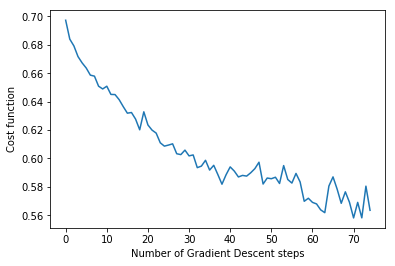

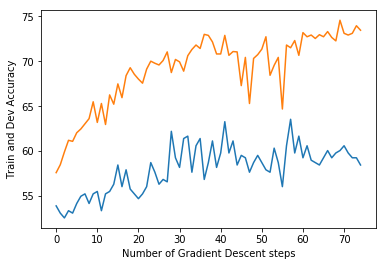

In [13]:
# (1) Hyperparameters
tf.reset_default_graph()
hidden_layer_size=35
learning_rate=.1
batch_size=50
num_ex=train_data.shape[0]
p_keep1=1.0

# define inputs
x_=tf.placeholder(tf.float32,shape=[None,max_len,300],name='x')
ns_=tf.placeholder(tf.int32,shape=[None],name='ns')
y_=tf.placeholder(tf.float32,shape=[None,2],name='y')
is_training_ = tf.placeholder_with_default(True, shape=[], name='is_training')


#define bow encoding layer


def bow_encoding_layer(x_,ns_,is_training=None):
    #Zero out padding embedding
    mask_ = tf.expand_dims(tf.sequence_mask(ns_, x_.shape[1],dtype=tf.float32), -1)
    x_=tf.multiply(x_,mask_)
    sum_embeddings=tf.reduce_sum(x_,axis=1)
    return sum_embeddings

#define model with one bow encoding layer, one hidden layer, and one output layer

def model(x_,ns_,hidden_layer_size,is_training=True):
    l1=bow_encoding_layer(x_,ns_)
    l2 = tf.layers.dropout(inputs = l1,rate = 1-p_keep1,training = is_training_)
    l3=tf.layers.dense(inputs=l2,units=hidden_layer_size,activation=tf.tanh)
    output_layer=tf.layers.dense(inputs=l3,units=2,activation=tf.nn.softmax)
    return output_layer

#Define training op and optimizer
preds=model(x_,ns_,hidden_layer_size,is_training_)
cc=tf.losses.softmax_cross_entropy(y_, preds)
gd=tf.train.GradientDescentOptimizer(learning_rate)
step=gd.minimize(cc)

#Define Accuracy calculation

def accuracy(predictions, labels): 
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])



#Train the Neural network, report dev/training accuracies
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    cost_vec_avg = []
    acc_dev_vec = []
    acc_train_vec = []
    for i in range(75):
        cost_vec = []
        for start, end in zip(range(0, num_ex, batch_size), range(batch_size, num_ex, batch_size)):
            batch = train_data[start:end], train_labels[start:end]
            ns=train_ns[start:end]
            _, cost = sess.run([step, cc], feed_dict={x_: batch[0],ns_: ns, y_: batch[1], is_training_: True})
            cost_vec.append(cost)
        
        train_acc = accuracy(preds.eval(feed_dict={x_: train_data,ns_: train_ns, is_training_: False}), train_labels)
        dev_acc = accuracy(preds.eval(feed_dict={x_: dev_data,ns_: dev_ns, is_training_: False}), dev_labels)
        
        cost_vec_avg.append(np.mean(cost_vec))
        clear_output(wait=True)
        acc_dev_vec.append(dev_acc)
        acc_train_vec.append(train_acc)
        print('%d) Dev Accuracy = %.4f' %(i+1, dev_acc))
        
    #get predicted labels for test set
    probas = preds.eval(feed_dict={x_: test_data,ns_: test_ns, is_training_: False})
    
#plot the results
plt.plot(cost_vec_avg)  
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Cost function')
plt.show()

plt.plot(acc_dev_vec)  
plt.plot(acc_train_vec)
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Train and Dev Accuracy')
plt.show()

In [14]:
predictions=np.argmax(probas,axis=1)
actual_labels=np.argmax(test_labels,axis=1)
print('test_set accuraccy: ',np.mean(predictions==actual_labels))
true_positives=float(((actual_labels==predictions) & (actual_labels==1)).sum())
false_positives=float(((actual_labels!=predictions) & (predictions==1)).sum())
false_negatives=float(((actual_labels!=predictions) & (actual_labels==1)).sum())
precision=true_positives/(true_positives+false_positives)
recall=true_positives/(true_positives+false_negatives)
f1=2*(precision*recall)/(precision+recall)
print('F1 Score: ', f1)
print(classification_report(actual_labels, predictions, target_names=['Liberal','Conservative']))

test_set accuraccy:  0.634899328859
F1 Score:  0.5261324041811846
              precision    recall  f1-score   support

     Liberal       0.63      0.79      0.70       407
Conservative       0.64      0.45      0.53       338

 avg / total       0.64      0.63      0.62       745



The gap between the train and dev set accuracy in the graph above indicates that the model might be slightly overfitting the IBC data.  However, attempts to reduce this overfitting, like a decreased learning rate, smaller hidden layer size and increased dropout probability have yielded worse performance on the test set.